In [1]:
from hyp_solver3 import HypProblem, Mesh, Solver, solve_oc
import matplotlib.pyplot as plt
import numpy as np
import scipy
from time import time

In [2]:
def plot_sys(mesh):
    plt.figure(figsize=(12,6))
    
    nodes = mesh.get_border(type_border="final", sort_s=True)
    s = [node[0][2] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    
    plt.subplot(3, 2, 1)
    plt.plot(s, x, "ro")
    plt.plot(s, [x_an(si, T[1]) for si in s], "b-")
    plt.ylabel("x")
    plt.grid()
    plt.subplot(3, 2, 3)
    plt.plot(s, y, "ro")
    plt.plot(s, [y_an(si, T[1]) for si in s], "b-")
    plt.ylabel("y")
    plt.xlabel("s")
    plt.grid()

    deltas_x = [abs(xi-x_an(si,T[1])) for si, xi in zip(s, x)]
    deltas_y = [abs(yi-y_an(si,T[1])) for si, yi in zip(s, y)]
        
    print(f"t= t1:\n\tdx:{np.max(deltas_x)}\n\tdy:{np.max(deltas_y)}")

    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    x = [node[1][0][0] for node in nodes]
    y = [node[1][0][1] for node in nodes]
    plt.subplot(3, 2, 2)
    plt.plot(t, x, "ro")
    plt.plot(t, [x_an(S[0], ti) for ti in t], "b-")
    plt.grid()
    plt.legend(["x", "x_an"])
    plt.subplot(3, 2, 4)
    plt.plot(t, y, "ro")
    plt.plot(t, [y_an(S[0], ti) for ti in t], "b-")
    plt.legend(["y", "y_an"])
    plt.grid()

    deltas_x = [abs(xi-x_an(S[0],ti)) for ti, xi in zip(t, x)]
    deltas_y = [abs(yi-y_an(S[0],ti)) for ti, yi in zip(t, y)]
        
    print(f"s=s0:\n\tdx:{np.max(deltas_x)}\n\tdy:{np.max(deltas_y)}")

    
    nodes = mesh.get_border(type_border="left", sort_t=True)
    t = [node[0][3] for node in nodes]
    v_true = [G22_true(ti) for ti in t]
    v = [hyp_problem.G22(ti) for ti in t]
    plt.subplot(3, 2, 6)
    plt.plot(t, v, "ro")
    plt.plot(t, v_true, "b-")
    plt.legend(["v", "v_an"])
    plt.ylabel("v")
    plt.xlabel("t")
    plt.grid()

In [3]:
G11_true = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G22_true = lambda t: - (np.sin(t)) / (np.cos(t) - 4* np.sin(t))

x0 = lambda s: 0
y0 = lambda s: (3*s+1)/(2*(s+1))

x_an = lambda s, t: 2*(s**2+1)*np.sin(t)
y_an = lambda s, t: (3*s+1)/(2*(s+1))*np.cos(t)
T = [0, 0.2]
S = [0, 1]
C = [1,2]
# C = [2.3,0.9]

B11 = lambda s, t: -2*s
B12 = lambda s, t: 4/3*s**2
B21 = lambda s, t: - (3*s+1)/(4*(s**2+1)*(s+1))
B22 = lambda s, t: 4/((s+1)*(3*s+1))

G11 = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G12 = lambda t: - G11(t)
G21_ = lambda t: (np.sin(t)) / (np.cos(t) - 4* np.sin(t))
G21 = lambda t: G21_(t) - 1
G22 = lambda t: - G21(t)

F1 = lambda s, t: 4*s**3*np.sin(t)+2*np.cos(t)+4*s**2*np.cos(t)/(3*(s+1))
F2 = lambda s, t: 0

phi_dx = lambda s, x, y : -2*(x - x_an(s, T[1])) 
phi_dy = lambda s, x, y : -2*(y - y_an(s, T[1]))

hyp_problem = HypProblem(T=T, S=S, C=C, B=[[B11, B12], [B21, B22]], 
                         F=[F1, F2], G=[[G11, G12], [G21, G22]], 
                         X0=x0, Y0=y0, phi_dx=phi_dx, phi_dy=phi_dy)

mesh = Mesh(hyp_problem, 100)
solver = Solver()
solver.solve_initial(mesh, hyp_problem)
solver.solver_center(mesh, hyp_problem)
solver.solver_final(mesh, hyp_problem)


t= t1:
	dx:0.00013846054179433853
	dy:0.06704426898888038
s=s0:
	dx:3.216527706562111e-05
	dy:0.06436294146277777


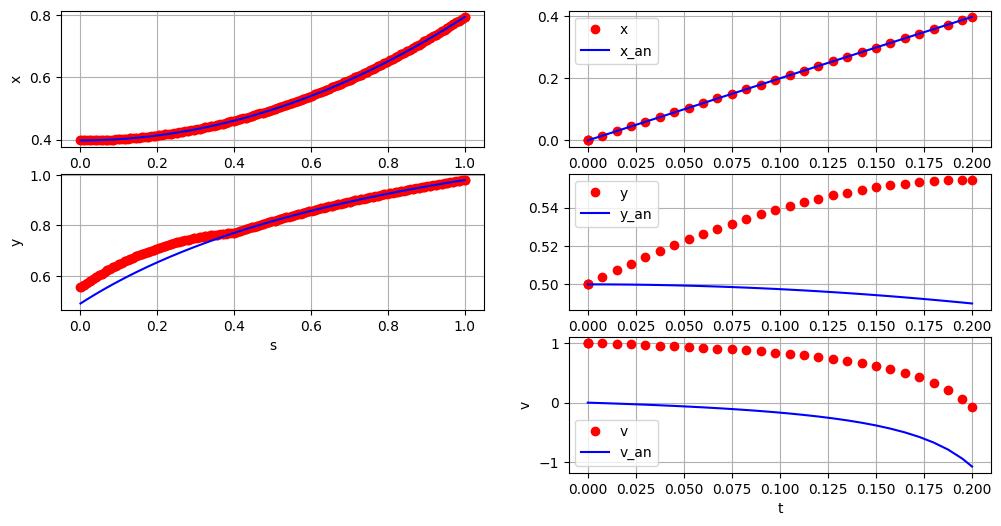

In [4]:
plot_sys(mesh)

$$h(p,x, y,u, t) = p_1 G_{11}(t)[y(s_1, t)-x(s_1, t)] + p_2u(t)[x(s_0, t)-y(s_0, t)]$$

$$h_u(p,x, y,u, t) = p_2[x(s_0, t)-y(s_0, t)]$$

In [46]:
import numpy as np
import scipy

# from .problem import HypProblem
# from .mesh import Mesh
# from .solver import Solver
from typing import List, Callable

ALPHA_HYSTORY = 0
EPS_HYSTORY = 0
MAX_STEP_ALPHA = 10
MAX_ITERATION = 20


class OCProblem:
    def __init__(self, hyp_problem: HypProblem, mesh: Mesh, xs, ys) -> None:
        self.hyp_problem = hyp_problem
        self.mesh = mesh
        self.solver = Solver()

        self.rezid = []

        self.xs = xs
        self.ys = ys

        nodes = mesh.get_border(type_border="left", sort_t=True)
        t_mesh = [node[0][3] for node in nodes]
        self.t_index = []
        self.t_hash = []
        for i, e in enumerate(t_mesh):
            if not e in self.t_hash:
                self.t_hash.append(e)
                self.t_index.append(i)

    def solve(self):
        self.solver.solve_initial(self.mesh, self.hyp_problem)
        self.solver.solver_center(self.mesh, self.hyp_problem)
        self.solver.solver_final(self.mesh, self.hyp_problem)

    def solve_conj(self):
        self.solver.solver_initial_conj(self.mesh, self.hyp_problem)
        self.solver.solver_center_conj(self.mesh, self.hyp_problem)
        self.solver.solver_final_conj(self.mesh, self.hyp_problem) 

    def J(self, v):
        v_ = [v[ti] for ti in self.t_index]
        self.set_new_control(lambda ti: np.interp(ti, self.t_hash, v_))
        self.solve()

        nodes = self.mesh.get_border(type_border="final", sort_s=True)
        s_final = [node[0][2] for i, node in enumerate(nodes) if i in self.t_index]
        x_final = [node[1][0][0] for i, node in enumerate(nodes)if i in self.t_index]
        y_final = [node[1][0][1] for i, node in enumerate(nodes) if i in self.t_index]

        f = [(xi-self.xs(si))**2+(yi-self.ys(si))**2 for xi, yi, si in zip(x_final, y_final, s_final)]
        return scipy.integrate.trapezoid(f, s_final)


    def set_new_control(self, U):
        G22_0 = lambda t: U(t)
        G21_0 = lambda t: - G22_0(t)
        G11_0 = self.hyp_problem.G11
        G12_0 = self.hyp_problem.G12
        self.hyp_problem.set_G([[G11_0, G12_0], [G21_0, G22_0]])


def solve_oc2(hyp_problem: HypProblem, mesh: Mesh, 
             U0: Callable[[float], float], xs: Callable[[float], float], ys: Callable[[float], float], 
             u_lim: List, eps:float=0.000001, beta = 0.01, delta = 0.8, debug=True):
    EPS_HYSTORY = 0
    ALPHA_HYSTORY = 0
    """
    Solve problem:
    J(U) = int_S (x(s, t1)-xs(s))**2 ds + int_S (y(s, t1)-ys(s))**2 ds -> min
    xs, ys - functions

    U0 - start control
    U_lim = [u0, u1] - control limit 
    hyp_problem and mesh are problem
    
    stopping criteria
    int_T H(psi1^k, psi2^k, x^k, y^k, u^k, t)(u^{k+1}-u^k) dt < eps
    """
    oc_problem = OCProblem(hyp_problem, mesh, xs, ys)
    oc_problem.set_new_control(U0)

    
    
    for k in range(1, MAX_ITERATION):
        oc_problem.solve()
        oc_problem.solve_conj()
        nodes = mesh.get_border(type_border="left", sort_t=True)
        t = [node[0][3] for node in nodes]
        uk = [hyp_problem.G22(ti) for ti in t]
        over_uk, over_W, Theta_uk = get_over(nodes, uk, t, u_lim)
        
        oc_problem.rezid.append(Theta_uk)
        if debug:
            print("Оптимально" if Theta_uk <= eps else "Не оптимально")
            print(f"Невязка составляет: {Theta_uk:.6f}")
            print(40*"*")  
        if Theta_uk <= eps:
            if debug:
                print(f"Невязка составляет: {Theta_uk:.6f}")
                print( f"Решено на {k}-й итерации")
            break
        T = get_interval_T(over_W, Theta_uk, beta, delta)
        a = _alpha_test(oc_problem, uk, over_uk, T) 
        uk_a_min = uk_eps(uk, over_uk, T, a)
        oc_problem.set_new_control(lambda ti: np.interp(x=ti, xp=t, fp=uk_a_min))
        if debug:
            print("результат минимизации a = ", a)
    return oc_problem

def uk_eps(uk, over_uk, T, eps):
    uk_new = uk.copy()
    for Ti in T:
        tau, left, right = Ti
        ind_l = tau - int(left*eps[0])
        ind_r = tau + int(right*eps[0])
        uk_new[ind_l:ind_r] = uk_new[ind_l:ind_r] + eps[1]*(over_uk[ind_l:ind_r]-uk_new[ind_l:ind_r])
    return uk_new

def _alpha_test(oc_problem:OCProblem, uk, uk_new, T):
    global ALPHA_HYSTORY, EPS_HYSTORY
    EPS_HYSTORY = 0
    # ALPHA_HYSTORY = 0
    def fun(a):
        uk_a = uk_eps(uk, uk_new, T, a)
        return oc_problem.J(uk_a)
    
    eps = [1/(1+i+EPS_HYSTORY) for i in range(MAX_STEP_ALPHA)]
    a = [1/(1+i+ALPHA_HYSTORY) for i in range(MAX_STEP_ALPHA)]
    
    eps_and_a = [(e, ai) for e in eps for ai in a]
    J_min = np.inf
    i_min = 0
    start = False
    for i, arg in enumerate(eps_and_a):
        J = fun(arg)
        if J < J_min:
            J_min = J
            i_min = i
            start = True
        elif start:
            break
    EPS_HYSTORY = int(1/eps_and_a[i][0]-1)
    ALPHA_HYSTORY = int(1/eps_and_a[i][1]-1)
    return eps_and_a[i]

def get_over(nodes, uk, t, u_lim):
    hu = [node[1][1][2]*(node[1][0][0]-node[1][0][1]) for node in nodes]
    new_uk = []
    for uki, hui in zip(uk, hu):
        if hui == 0:
            new_uk.append(uki)
        elif hui > 0:
            new_uk.append(u_lim[1])
        else:
            new_uk.append(u_lim[0])
    
    over_W, Theta_uk = _get_resid(t, hu, new_uk, uk) 
    over_uk = np.array(new_uk)
    return over_uk, over_W, Theta_uk

def _get_resid(t_h, h_u_k, uk_new, uk):
    f = [h*(uk_new_i-uk_i) for h, uk_new_i, uk_i in zip(h_u_k, uk_new, uk) ]
    
    return f, scipy.integrate.trapezoid(f, t_h) / (t_h[-1]-t_h[0])

def get_index_interval(index, delta):
    max_T = np.sum(index)
    intervals = []
    start = False
    for i, iss in enumerate(index):
        if iss and not start:
            start = True
            len_ = 0
            intervals.append([i, 0])
        if start and not iss:
            start = False
        if start:
            intervals[-1][1] += 1
    len_ = np.array([inter[1] for inter in intervals])
    index_interval = reversed(np.argsort(len_))
    
    sum_ = 0
    T = []
    for i in index_interval:
        sum_+=len_[i]
        T.append(intervals[i])
        if sum_ > delta*max_T:
            return T
    return T

def get_interval_T(over_W, Theta_uk, beta, delta):
    index = over_W >= Theta_uk*beta   
    M = get_index_interval(index, delta)
    T = []
    for Ti in M:
        tau_index = np.argmax(over_W[Ti[0]:Ti[0]+Ti[1]])
        left_tau = tau_index - Ti[0]
        right_tau = Ti[1]-tau_index
        T.append((tau_index, left_tau, right_tau))
    return T

In [47]:
U0 = lambda t: G22(t)
xs = lambda s: x_an(s, T[1])
ys = lambda s: y_an(s, T[1])
start_time = time()
rez = solve_oc2(hyp_problem, mesh, U0, xs, ys, u_lim=[-2.5, 1], eps=0.000001, beta = 0.5, delta = 8.0, debug=True)
print(f"сек:{time()-start_time:.2f}")

Не оптимально
Невязка составляет: 0.035130
****************************************
результат минимизации a =  (1.0, 0.25)
Не оптимально
Невязка составляет: 0.004931
****************************************
результат минимизации a =  (1.0, 0.09090909090909091)
Не оптимально
Невязка составляет: 0.000481
****************************************
результат минимизации a =  (0.3333333333333333, 0.09090909090909091)
Не оптимально
Невязка составляет: 0.000319
****************************************
результат минимизации a =  (0.2, 0.09090909090909091)
Не оптимально
Невязка составляет: 0.000319
****************************************
результат минимизации a =  (0.2, 0.09090909090909091)
Не оптимально
Невязка составляет: 0.000319
****************************************
результат минимизации a =  (0.2, 0.09090909090909091)
Не оптимально
Невязка составляет: 0.000319
****************************************
результат минимизации a =  (0.2, 0.09090909090909091)
Не оптимально
Невязка составляет: 

KeyboardInterrupt: 

In [31]:
# U0 = lambda t: G22(t)
# xs = lambda s: x_an(s, T[1])
# ys = lambda s: y_an(s, T[1])
# start_time = time()
# rez = solve_oc(hyp_problem, mesh, U0, xs, ys, u_lim=[-2.5, 1], eps=0.000001, debug=True)
# print(f"сек:{time()-start_time:.2f}")

t= t1:
	dx:4.5944825772803455e-06
	dy:0.00716146304246601
s=s0:
	dx:4.5944825772803455e-06
	dy:0.00716146304246601


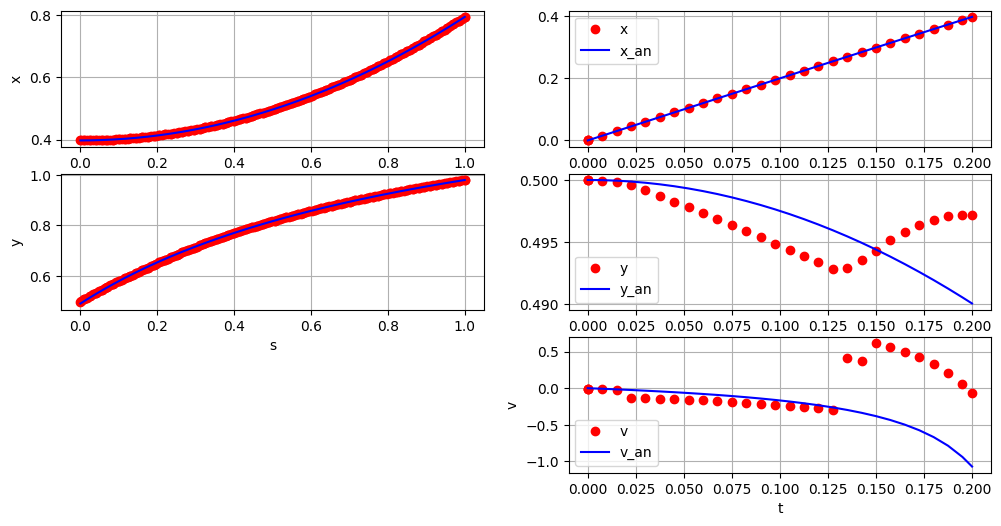

In [43]:
plot_sys(rez.mesh)

t= t1:
	dx:4.893479889744867e-06
	dy:0.008641358696859669
s=s0:
	dx:4.893479889744867e-06
	dy:0.008641358696859669


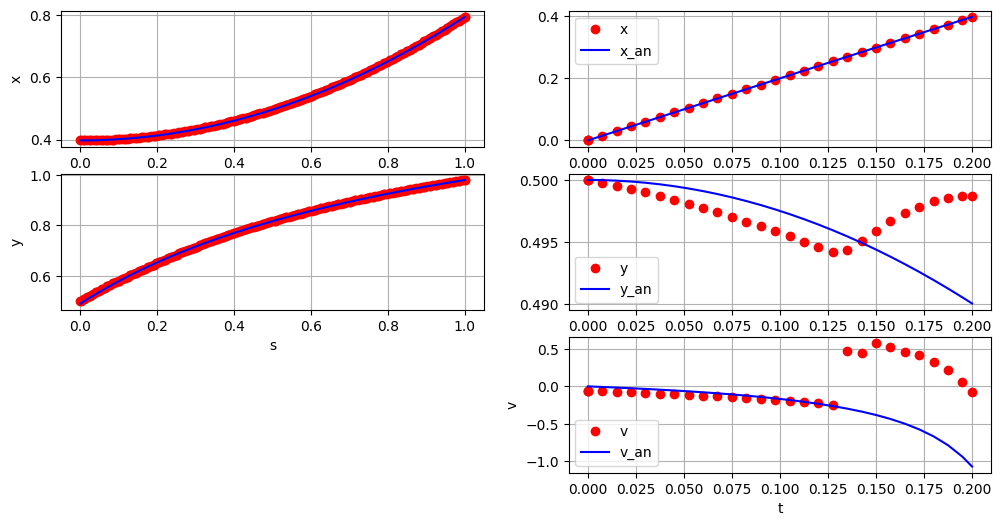

In [30]:
plot_sys(rez.mesh)

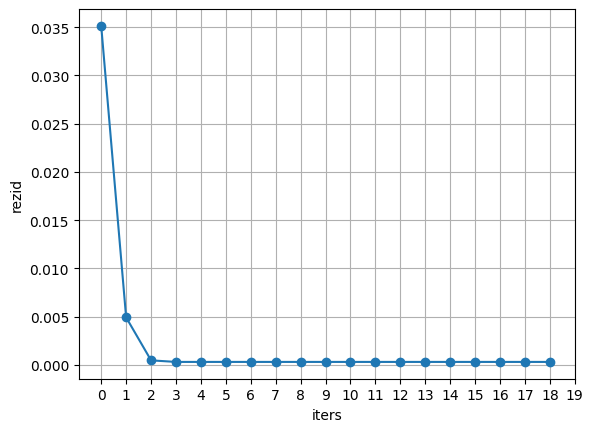

In [45]:
plt.plot(rez.rezid, "o-")
plt.xlabel("iters")
plt.ylabel("rezid")
plt.xticks([i for i in range(0, 20)])
plt.grid()